Lets start by visualizing the original soil moisture data, for a depth of 30 cm under the soil in a cropland rainfed near touluse, france. this model does not account for rain.

Field Capacity for SoilMoisture_0.3m (95th percentile): 0.3411125
VWC Threshold for SoilMoisture_0.3m: 0.23877874999999998


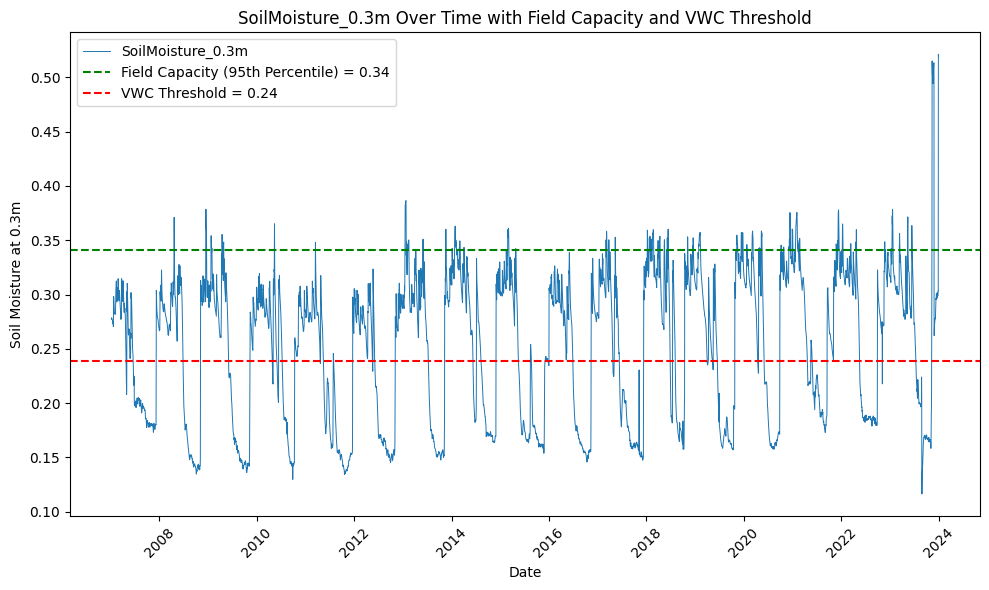

NameError: name 'simulate_irrigation' is not defined

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from functions.data_retrieval import *
from wheat_specifical import *


# Load your CSV file into a DataFrame
file_path = 'C:/Users/serafino/Desktop/Water Management System/Data Water 0.3m.csv'
data = pd.read_csv(file_path, delimiter=';')
data.columns = [col.strip() for col in data.columns]  # Clean up column names
# Convert DateTime to datetime format and set it as index
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)
# Apply unit conversion to SoilMoisture_0.3m column if values are above 1
data['SoilMoisture_0.3m'] = data['SoilMoisture_0.3m'].apply(lambda x: x / 1000 if x > 1 else x)


# Set the percentile to use for field capacity (95th percentile)
percentile_value = 95

# Calculate field capacity and VWC threshold once and reuse them
field_capacity = np.percentile(data['SoilMoisture_0.3m'].dropna(), percentile_value)
FTSW_thresh = 0.7
VWC_thresh = FTSW_thresh * field_capacity
VWC_irr = field_capacity  # Bring moisture back to field capacity after irrigation

# Print values for verification
print(f"Field Capacity for SoilMoisture_0.3m (95th percentile): {field_capacity}")
print(f"VWC Threshold for SoilMoisture_0.3m: {VWC_thresh}")

# Plot Soil Moisture over time with Field Capacity and VWC Threshold
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['SoilMoisture_0.3m'], label='SoilMoisture_0.3m', linewidth=0.7)
plt.axhline(y=field_capacity, color='green', linestyle='--', label=f'Field Capacity (95th Percentile) = {field_capacity:.2f}')
plt.axhline(y=VWC_thresh, color='red', linestyle='--', label=f'VWC Threshold = {VWC_thresh:.2f}')
plt.title('SoilMoisture_0.3m Over Time with Field Capacity and VWC Threshold')
plt.xlabel('Date')
plt.ylabel('Soil Moisture at 0.3m')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Simulate irrigation with the original soil moisture data
simulate_irrigation(data, 'SoilMoisture_0.3m', field_capacity, FTSW_thresh=0.7, FTSW_irr=1.0, root_zone_depth_1m=100, irrigation_efficiency=0.7, field_area=10000)

# Calculate daily water absorption by wheat based on temperature and soil moisture
daily_water_absorption_wheat(data, temp_column='Temp_2m', soil_moisture_column='SoilMoisture_0.3m')

# Calculate VWC change after wheat absorption (optimize by using vectorized operations)
root_zone_depth = 0.3  # Set root zone depth in meters
data['VWC_Change'] = data['Water_Absorbed_By_Wheat'] / (root_zone_depth * 1000)  # Convert mm to m³/m³

# Create updated soil moisture after wheat absorption, ensuring no negative values
data['Updated_SoilMoisture_Absorption'] = np.maximum(data['SoilMoisture_0.3m'] - data['VWC_Change'], 0)

# Simulate irrigation on the updated soil moisture column
simulate_irrigation(data, 'Updated_SoilMoisture_Absorption', field_capacity, FTSW_thresh=0.7, FTSW_irr=1.0, root_zone_depth_1m=100, irrigation_efficiency=0.7, field_area=10000)


Now, we will estimate the values of soil moisture for 2024 and 2025. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load your CSV file into a DataFrame (adjust the file path as necessary)
file_path = '/Users/eugenioserafino/Desktop/Semester Project/Saint Felix de Lauragais/Combined_Soil_Moisture_and_Satellite_Data_Interpolated.csv'
data = pd.read_csv(file_path)

# Ensure DateTime is in correct format and set it as index
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)

# Focus on the column with soil moisture data
soil_moisture = data['SoilMoisture_0.3m'].dropna()

# Decompose the time series into trend, seasonality, and residual components
decomposition = seasonal_decompose(soil_moisture, model='additive', period=365)  # Assuming daily data with yearly seasonality

# Plot the decomposition
decomposition.plot()
plt.show()

# Now, fit a SARIMA model (Seasonal ARIMA) to forecast future data
# The order (p,d,q) and seasonal order (P,D,Q,s) might need tuning based on AIC/BIC values.
model = SARIMAX(soil_moisture, order=(1,1,1), seasonal_order=(1,1,1,365))
sarima_fit = model.fit(disp=False)

# Forecast the soil moisture until the end of 2025
forecast_steps = (pd.Timestamp('2025-31-12') - soil_moisture.index[-1]).days  # Number of days to forecast
forecast = sarima_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=soil_moisture.index[-1], periods=forecast_steps, freq='D')
forecast_values = forecast.predicted_mean

# Plot the historical data and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(soil_moisture, label='Historical SoilMoisture_0.3m')
plt.plot(forecast_index, forecast_values, label='Forecasted SoilMoisture_0.3m', color='red')
plt.fill_between(forecast_index, forecast.conf_int()['lower SoilMoisture_0.3m'], forecast.conf_int()['upper SoilMoisture_0.3m'], color='red', alpha=0.3)
plt.title('Soil Moisture Forecast (2023-2025)')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optionally, save the forecasted values to a CSV
forecast_df = pd.DataFrame({'DateTime': forecast_index, 'Forecasted_SoilMoisture_0.3m': forecast_values})
forecast_df.to_csv('/Users/eugenioserafino/Desktop/Semester Project/SoilMoisture_Forecast_2023_2025.csv', index=False)




ModuleNotFoundError: No module named 'statsmodels'

now we will incorporate the ET for the spring wheat crop, and this will affect the humidity of the terrain. we assume it will be planted on the 20th of april each year.